<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/7%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_1018_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽가이드 개정2판 ch 9.5

p.601-613

# [Chapter 9] 추천 시스템

## 9-5. 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트

### 장르 속성을 이용한 영화 콘텐츠 기반 필터링

- 콘텐츠 기반 필터링 : 사용자가 좋아하는 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것
  - 영화 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 평점, 키워드, 영화 설명)를 기반으로 함
  - 장르 칼럼 값의 유사도를 비교한 뒤, 그 중 높은 평점을 가지는 영화를 추천

### 데이터 로딩 및 가공

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [2]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

- id
- title : 영화 제목
- genres
- vote_average : 평균 평점
- vote_count : 평점 투표수
- popularity : 영화의 인기
- keywords : 영화를 설명하는 주요 키워드
- overview : 영화에 대한 개요 설명

In [3]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


- genres 칼럼 : 여러 개의 개별 장르 데이터를 가지고 있으므로, 딕셔너리의 키인 'name'으로 장르 추출
- keywords 칼럼도 동일 방식으로 추출

In [4]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

- literal_eval() : 문자열이 의미하는 list [dict1, dict2] 객체로 변환

In [5]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


### 장르 콘텐츠 유사도 측정

- 장르별 유사도 측정 방법
  - 하나의 영화에 다양한 장르 존재
  - geres를 문자열로 변경한 뒤, CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교
  1. 문자열로 변환된 genres 칼럼 Count 기반으로 피처 벡터화
  2. 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도로 비교
  3. 장르 유사도가 높은 영화 중 평점이 높은 순으로 영화 추천

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환.
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0.0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


In [9]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


- argsort() : 값이 높은 순으로 정렬된 행의 '위치 인덱스'
- 0번 레코드의 경우 자신을 제외하면 3494번 레코드와 가장 유사도가 높고, 2401번 레코드와 가장 유사도가 낮음

### 장르 콘텐츠 필터링을 이용한 영화 추천

In [10]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title'] == title_name]

  # title_name을 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터임.
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [11]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- 'The Godfather: Part II', 'GoodFellas' 등 추천 영화로 알맞은 영화도 있지만 'Light Sleeper', 'Mi America', 'Kids' 등 추천하기에 적절하지 않은 영화들도 있으므로 개선 필요

In [12]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average',
                                                               ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


- 유명한 영화보다 평점이 높은 영화 존재 (평가 횟수 매우 작음)
- 왜곡된 평점 데이터를 피하기 위해 가중치가 부여된 평점(Weighted Rating) 사용
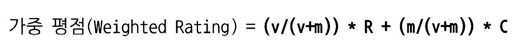

- v : 개별 영화의 투표 횟수 (vote_count)
- m : 평점을 부여하기 위한 최소 투표 횟수
- R : 개별 영화의 평균 평점 (vote_average)
- C : 전체 영화에 대한 평균 평점 (movies_df['vote_average].mean())

In [13]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


- m 값을 높이면 평점 토표 횟수가 많은 영화에 더 많은 가중 평점 부여

In [14]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ( (v/(v+m)) * R) + ( (m/(m+v)) * C)

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [16]:
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values(
    'weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


- 새롭게 부여된 weighted_vote 평점을 기준으로 정렬한 결과, 앞선 결과보다 더 신뢰할 수 있는 결과임

In [17]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
